In [1]:
import xarray as xr
import fsspec
import matplotlib.pyplot as plt
import numpy as np

In [2]:
path = '/work/users/my982hzao/'

ds = xr.open_zarr(fsspec.get_mapper(path + 'S2_Frankenwald_CF_20.zarr'), \
                  consolidated=True)

In [3]:
def greeness(ds):
    return -0.283 * ds.sel(band=3) - 0.660 * ds.sel(band=4) + 0.577 * ds.sel(band=6) + 0.388 * ds.sel(band=9)

def brightness(ds):
    return 0.3037 * ds.sel(band=2) + 0.2793 * ds.sel(band=3) + 0.5585 * ds.sel(band=4) + 0.5585 * ds.sel(band=8) + 0.5082 * ds.sel(band=10) + 0.1863 * ds.sel(band=12)

def wetness(ds):
    return 0.1509 * ds.sel(band=2) + 0.1973 * ds.sel(band=3) + 0.3279 * ds.sel(band=4) + 0.3406 * ds.sel(band=8) - 0.7112 * ds.sel(band=11) - 0.4572 * ds.sel(band=12)

G_raw, B_raw, W_raw = greeness(ds.refl), brightness(ds.refl), wetness(ds.refl)


G_mean = G_raw.sel(time='2017-03-26').mean()
G_std  = G_raw.sel(time='2017-03-26').std()

W_mean = W_raw.sel(time='2017-03-26').mean()
W_std  = W_raw.sel(time='2017-03-26').std()

B_mean = B_raw.sel(time='2017-03-26').mean()
B_std  = B_raw.sel(time='2017-03-26').std()

B = (B_raw - B_mean) / B_std
G = (G_raw - G_mean) / G_std
W = (W_raw - W_mean) / W_std

DI = B - (G + W)


In [4]:
for i in [1, 2, 3]:
    print(ds.attrs['forest region'][str(i)])

Thüringer Wald
Thüringer Schiefergebirge
Frankenwald


In [5]:
reference_period = (DI.time.dt.year == 2017)
not_winter = ((DI.time.dt.month < 12) & (DI.time.dt.month > 3))
DI_reference = DI.isel(time=reference_period & not_winter).mean(dim='time')

In [17]:
reference_period = (DI.time.dt.year == 2017)
not_winter = ((DI.time.dt.month < 12) & (DI.time.dt.month > 3))
DI_reference = DI.isel(time=reference_period & not_winter).mean(dim='time')

for region in [3]:
    di_region = DI.isel(time=not_winter).where(ds.forest_region == region)
    di_reference = DI_reference.where(ds.forest_region == region)
    label = ds.attrs['forest region'][str(region)]
    (di_region - di_reference).quantile(0.5, dim=['lat', 'lon']).plot(marker='o', label=label, linewidth=1, linestyle='--')
plt.legend()

ValueError: dimension lat on 0th function argument to apply_ufunc with dask='parallelized' consists of multiple chunks, but is also a core dimension. To fix, either rechunk into a single dask array chunk along this dimension, i.e., ``.chunk(dict(lat=-1))``, or pass ``allow_rechunk=True`` in ``dask_gufunc_kwargs`` but beware that this may significantly increase memory usage.

In [7]:
DI

<xarray.DataArray 'refl' (time: 68, lat: 7530, lon: 11540)>
dask.array<sub, shape=(68, 7530, 11540), dtype=float64, chunksize=(1, 471, 1443), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 50.97 50.97 50.97 50.97 ... 50.31 50.31 50.31 50.31
  * lon      (lon) float64 10.29 10.29 10.29 10.29 ... 11.96 11.96 11.96 11.96
  * time     (time) datetime64[ns] 2017-01-22 2017-03-26 ... 2022-12-11

In [8]:
ds

<xarray.Dataset>
Dimensions:        (time: 68, band: 12, lat: 7530, lon: 11540)
Coordinates:
  * band           (band) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat            (lat) float64 50.97 50.97 50.97 50.97 ... 50.31 50.31 50.31
  * lon            (lon) float64 10.29 10.29 10.29 10.29 ... 11.96 11.96 11.96
  * time           (time) datetime64[ns] 2017-01-22 2017-03-26 ... 2022-12-11
Data variables:
    CF             (time) float64 dask.array<chunksize=(68,), meta=np.ndarray>
    forest_mask    (lat, lon) float64 dask.array<chunksize=(942, 1443), meta=np.ndarray>
    forest_region  (lat, lon) int64 dask.array<chunksize=(942, 1443), meta=np.ndarray>
    mask           (time, lat, lon) int8 dask.array<chunksize=(1, 942, 1443), meta=np.ndarray>
    refl           (time, band, lat, lon) float64 dask.array<chunksize=(1, 1, 471, 1443), meta=np.ndarray>
Attributes: (12/14)
    author:                       Joshua Müller
    band_dimension:               bands
    band_scale_factor:            10000
    band_units:                   DN
    coordinate_reference_system:  EPSG:4326
    creation_date:                2023-02-13
    ...                           ...
    platform:                     Sentinel-2
    product_type:                 Level-2A
    projection:                   plane
    resolution:                   10m
    wavelength_units:             nanometers
    wavelengths:                  [443, 490, 560, 665, 705, 740, 783, 832, 94...

DI.

In [9]:
from tqdm import tqdm

def indentify_dead_trees(DI):

    dim_time, dim_lat, dim_lon = DI.shape       
    loss_map = np.zeros((dim_lat, dim_lon)) * np.nan

    

    for time in range(dim_time):
        loss_map = DI.isel(time=time).where(DI.isel(time=time) > 12,  DI.time.dt.year[time].values)                    
    forest_loss_map = xr.DataArray(
        data= loss_map,
        dims= ["lat", 'lon'],
        coords=dict(
            lat = DI.lat.values,
            lon = DI.lon.values,
        ),

    )
    return forest_loss_map


    

In [10]:
loss_map = indentify_dead_trees(DI - DI_reference)



In [11]:

c1 = 50.34974098696109, 11.35

lat_slice = slice(c1[0] + 0.02, c1[0] - 0.02)
lon_slice = slice(c1[1] - 0.02, c1[1] + 0.02)

In [12]:
not_winter = ((DI.time.dt.month < 11) & (DI.time.dt.month > 6))

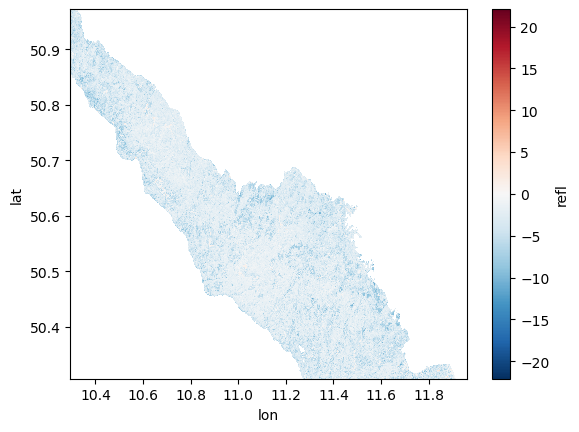

In [13]:
DI_reference.plot()

In [14]:
c1 = 50.34974098696109, 11.35
c2 = 50.38824817689809, 11.290368793844134
c3 = 50.34722156778008, 11.358770488000598

lat_slice = slice(c1[0] + 0.02, c1[0] - 0.02)
lon_slice = slice(c1[1] - 0.02, c1[1] + 0.02)

di_c1 = DI.sel(lat=lat_slice, lon=lon_slice)
di_c1_reference = DI_reference.sel(lat=lat_slice, lon=lon_slice).mean()

In [15]:
(dsf_slice == 1) | (dsf_slice == 2)

NameError: name 'dsf_slice' is not defined

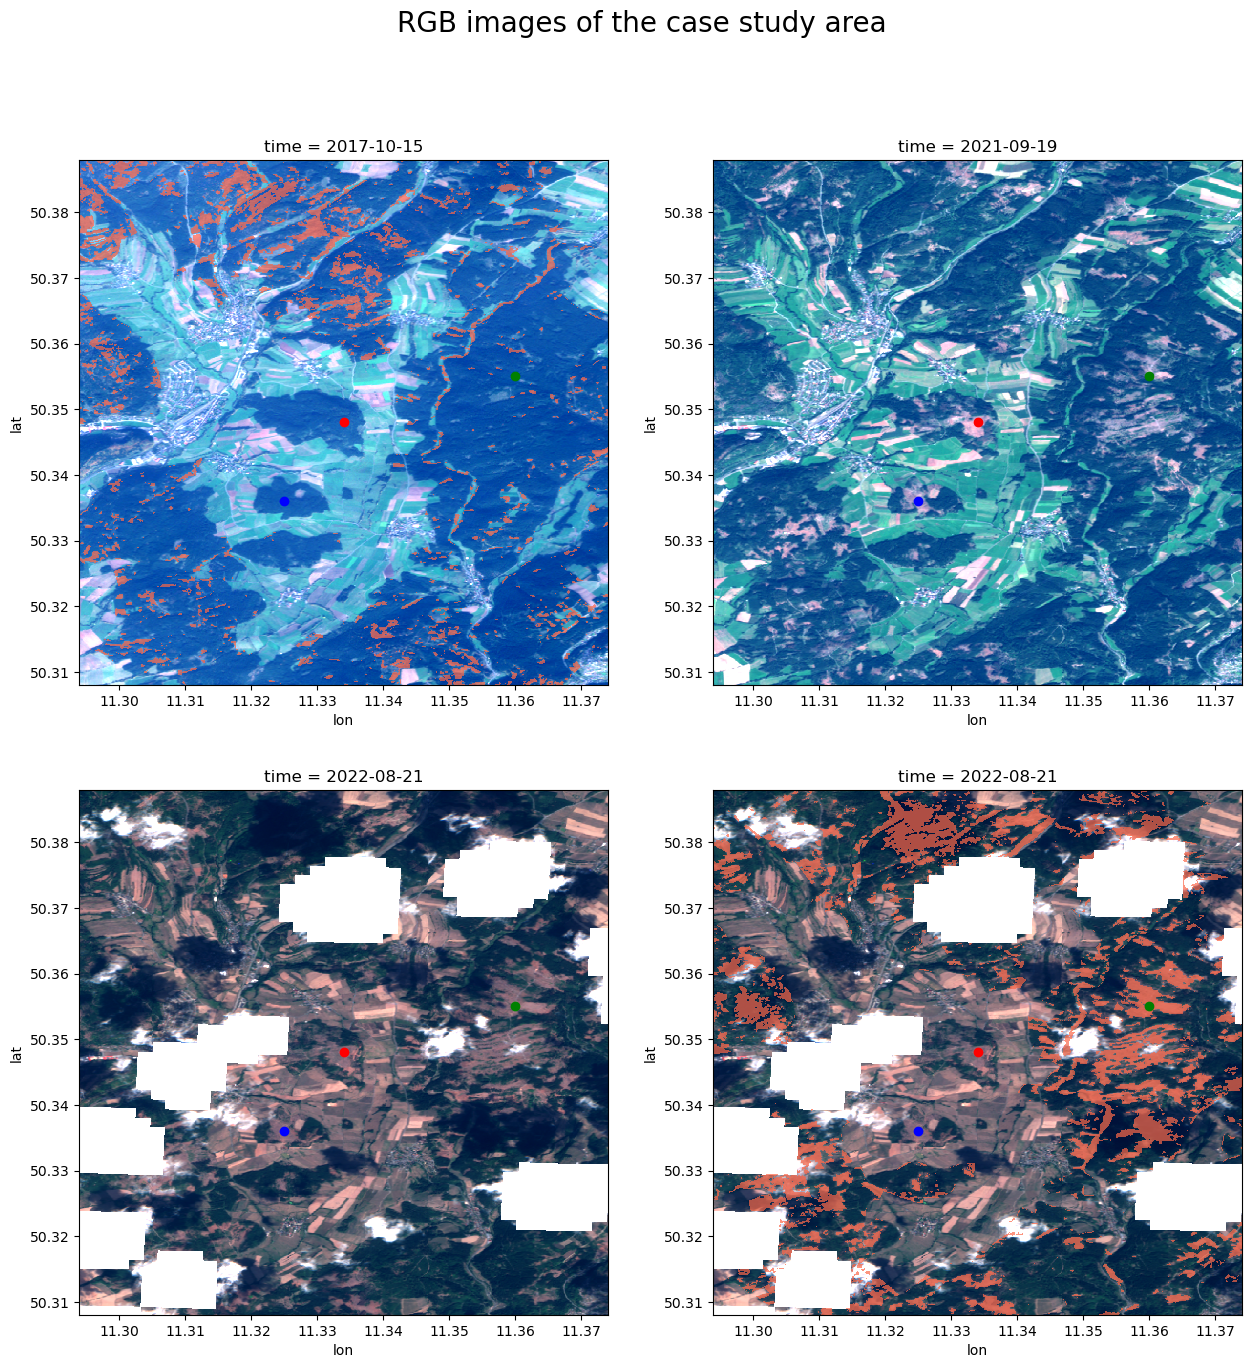

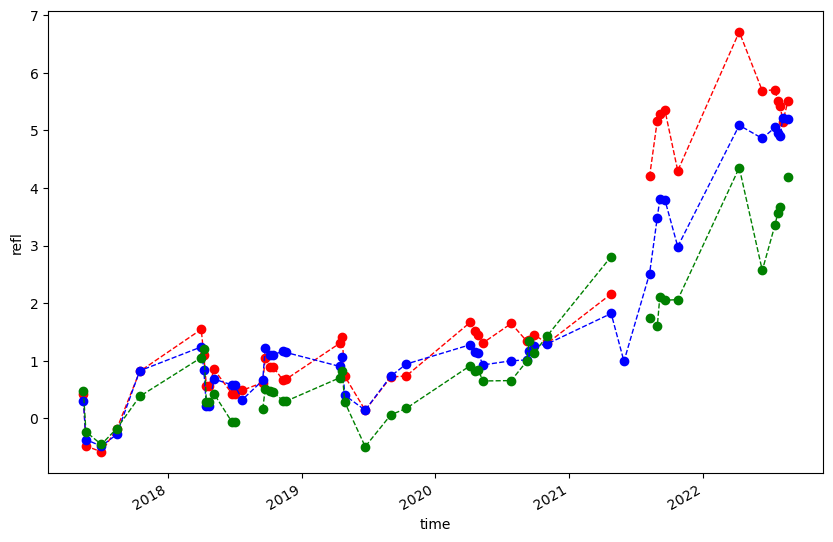

In [ ]:
c1 = 50.348, 11.334
c2 = 50.336, 11.325
c3 = 50.355,  11.36

lat_slice = slice(c1[0] + 0.04, c1[0] - 0.04)
lon_slice = slice(c1[1] - 0.04, c1[1] + 0.04)


fig, axs = plt.subplots(2, 2, figsize=(15, 15))
c = 0

for time, ax  in zip(['2017-09-20', '2021-09-20', '2022-09-20', '2022-09-20'], axs.flatten()):
    
    dsf_slice = ds.forest_region.sel(lat=lat_slice, lon=lon_slice) 
    

    RGB = (ds['refl'].sel(band = [4, 3 ,2]) / 10000 * 3.5 ).sel(time=time, method='nearest')

    RGB.sel(lat=lat_slice, lon=lon_slice).plot.imshow(robust=True, ax= ax)
    
    detected_dead_trees = ((DI.sel(time=time, method='nearest').sel(lat=lat_slice, lon=lon_slice) - DI_reference) > 3)\
    .where((dsf_slice == 3) | (dsf_slice==2))
    
    if c < 1 or c > 2:
    
        detected_dead_trees.where(detected_dead_trees > 0).plot(cmap='Reds', alpha=0.7, ax=ax, add_colorbar = False)
    
    ax.plot(c1[1], c1[0], 'ro')
    ax.plot(c2[1], c2[0], 'bo')
    ax.plot(c3[1], c3[0], 'go')
    c += 1

fig.suptitle('RGB images of the case study area', fontsize=20)
plt.figure(figsize=(10, 6))

plt.title('Disturbance index timeseries of selected sites')
plot_case_study(DI, DI_reference, c1, color='r')
plot_case_study(DI, DI_reference, c2, color = 'b')
plot_case_study(DI, DI_reference, c3, color = 'g')


In [ ]:
def plot_case_study(di, di_reference, coords, color):
    lat_slice = slice(coords[0] + 0.001, coords[0] - 0.001)
    lon_slice = slice(coords[1] - 0.001, coords[1] + 0.001)

    di = di.sel(lat=lat_slice, lon=lon_slice).mean(dim=['lat', 'lon']).isel(time=not_winter)
    di_reference = di_reference.sel(lat=lat_slice, lon=lon_slice).mean()

    (di - di_reference).plot(marker='o', linewidth=1, linestyle='--', color=color)



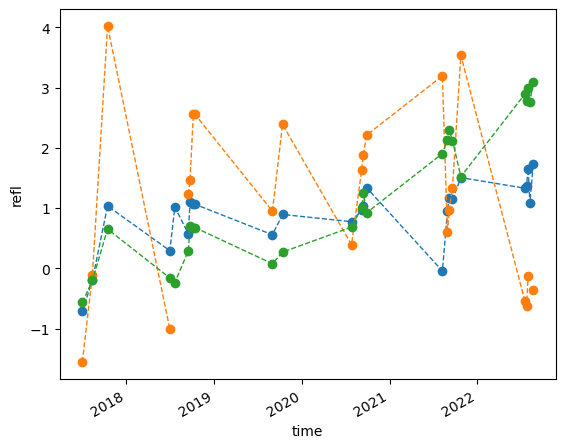

In [ ]:
plot_case_study(DI, DI_reference, c1)
plot_case_study(DI, DI_reference, c2)


In [ ]:
a = DI.sel(time=slice('2021-06-01', '2021-10-01')).mean(dim='time').where(ds.forest_region == 3) - DI_reference.where(ds.forest_region == 3)


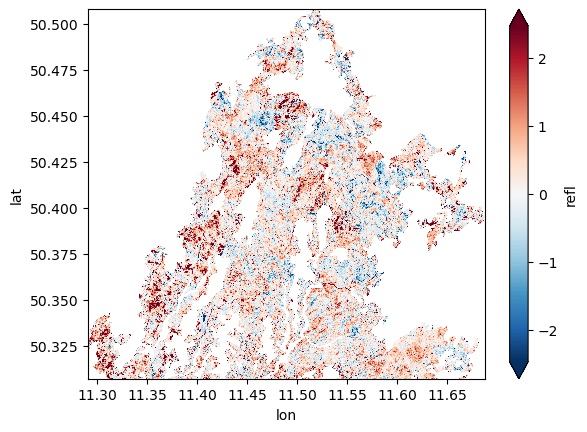

In [ ]:
a.dropna(dim='lat', how='all').dropna(dim='lon', how='all').plot(robust=True)